In [0]:
import keras
from keras.engine import Layer
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import Conv2D, Conv3D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.callbacks import TensorBoard
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
# tf.disable_v2_behavior()
from keras.losses import mae
from keras.layers.core import RepeatVector
from google.colab import drive

In [0]:
#IMPORTING INCEPTION RESNET V2 WEIGHTS
inception = InceptionResNetV2(weights='imagenet', include_top=True)       #pre-trained model for feature extraction
inception.graph = tf.get_default_graph()

for layer in inception.layers:                                          
    layer.trainable=False

In [0]:
from google.colab import drive
drive.mount('/content/drive/')
#drive.mount('Nandini')

In [0]:
#READING 10000 FACES DATASET AND APPENDING TO ARRAY X
path='/content/drive/My Drive/ml project/10000-20191123T180734Z-003/10000/'
#path='Nandini/My Drive/ML/10000-20191123T180734Z-003/10000/'
X=[]
i=0
for filename in os.listdir(path):
  if i==1500:
    break
  print(i)
  X.append(img_to_array(load_img(path+filename)))
  i=i+1 
# print(len(X))
print("Images read")

In [0]:
#CONVERTING INPUT FROM RGB TO LAB AND SAVING INTO Xtrain AND Ytrain AS INDEPENDENT AND DEPENDENT VARIABLES
X=np.array(X)
print(X.shape)
X=1.0/255*X #normalizing because rgb2lab converts (0,1) to (-128,128) for ab channels and (-100,100) for L channel
Xtrain=[]
Ytrain=[]
for i in X:
    lab_img= rgb2lab(i)
    l_values=lab_img[:,:,0]               #l channel of the lab image
    ab_values=lab_img[:,:,1:]/128         #ab channels of the lab image. Normalized it to get values between -1 and 1
    Xtrain.append(l_values)
    Ytrain.append(ab_values)  

(1500, 256, 256, 3)


In [0]:
#CONVERTING Xtrain AND Ytrain TO NUMPY ARRAYS FOR EASIER COMPUTATION
Xtrain=np.array(Xtrain)
Ytrain=np.array(Ytrain)
Xtrain=Xtrain.reshape(Xtrain.shape+(1,))
print(Xtrain.shape)

(1500, 256, 256, 1)


In [0]:
#TO SAVE INPUTS (X AND Y) IF NEEDED
np.save("/content/drive/My Drive/ml project/numpy/Xtrain_input_1500.npy",Xtrain)
np.save("/content/drive/My Drive/ml project/numpy/Ytrain_input_1500.npy",Ytrain)

In [0]:
#LOADING FROM SAVED INPUTS
Xtrain=[]
Xtrain=np.load("/content/drive/My Drive/ml project/numpy/Xtrain_input_1500.npy")
Xtrain=np.array(Xtrain)

Ytrain=[]
Ytrain=np.load("/content/drive/My Drive/ml project/numpy/Ytrain_input_1500.npy")
Ytrain=np.array(Ytrain)

In [0]:
#LOADING FROM SAVED FEATURES
features_from_inception = [] #features passed to inception resnet model and saved from before
features_from_inception=np.load("/content/drive/My Drive/ml project/numpy/features_from_inception_1500_face.npy")
features_from_inception=np.array(features_from_inception)

In [0]:
#MAIN MODEL
feature_input_from_inception = Input(shape=(1000,))

#Encoder that reduces dimensions and removes noise to extract local features
input_to_extraction = Input(shape=(256, 256, 1,))
extraction_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(input_to_extraction)
extraction_output = Conv2D(128, (3,3), activation='relu', padding='same')(extraction_output)
extraction_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(extraction_output) #strides=2 halves the first 2 dimensions
extraction_output = Conv2D(256, (3,3), activation='relu',padding='same')(extraction_output)
extraction_output = Dropout(0.35)(extraction_output)
extraction_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(extraction_output) #output of dim 32, 32, 256
extraction_output = Conv2D(512, (3,3), activation='relu', padding='same')(extraction_output)
extraction_output = Dropout(0.35)(extraction_output)
extraction_output = Conv2D(256, (3,3), activation='relu', padding='same')(extraction_output)
extraction_output = Conv2D(256, (3,3), activation='relu', padding='same')(extraction_output) #optional - can add more layers

#Global features obtained from inception resnet model are combined with local features of the compressed image extracted by encoder
bottleneck = RepeatVector(32 * 32)(feature_input_from_inception) #To basically add a repeat vector of (Number of examples,32,1000) 
bottleneck = Reshape(([32, 32, 1000]))(bottleneck)
bottleneck = concatenate([extraction_output, bottleneck], axis=3)

#Decoder that expands dimensions to reconstruct original image
colorizer_output = Conv2D(256, (1, 1), activation='relu', padding='same')(bottleneck) 
colorizer_output = Conv2D(128, (3,3), activation='relu', padding='same')(colorizer_output)
colorizer_output = UpSampling2D((2, 2))(colorizer_output)
colorizer_output = Conv2D(64, (3,3), activation='relu', padding='same')(colorizer_output)
colorizer_output = Dropout(0.35)(colorizer_output)
colorizer_output = UpSampling2D((2, 2))(colorizer_output)
colorizer_output = Conv2D(32, (3,3), activation='relu', padding='same')(colorizer_output)
colorizer_output = Dropout(0.35)(colorizer_output)
colorizer_output = Conv2D(16, (3,3), activation='relu', padding='same')(colorizer_output)
colorizer_output = Dropout(0.35)(colorizer_output)
colorizer_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(colorizer_output)
colorizer_output = UpSampling2D((2, 2))(colorizer_output) #output of dim 256, 256, 2

model = Model(inputs=[input_to_extraction, feature_input_from_inception], outputs = colorizer_output)
from keras.utils import plot_model
plot_model(model)    


In [0]:
#COMPUTING FEATURES USING INCEPTION RESNET MODEL. INCEPTION RESNET MODEL GIVES PROBABILITIES OF 1000 CLASSES
features_from_inception=[]
for l_image in Xtrain:
  l_image= resize(l_image,(299,299,1))      #because of inception resnet v2
  l_image=gray2rgb(l_image)
  l_image=resize(l_image,(1,299,299,3))     #sending 1 image to the pretained model
  prediction= inception.predict(l_image)
  prediction=prediction[0]                  #prediction needs to be reshaped from (1,1000) to 1000
  features_from_inception.append(prediction)
features_from_inception=np.array(features_from_inception)
np.save("/content/drive/My Drive/ml project/numpy/features_from_inception_2000_face.npy",features_from_inception)
print("Array saved")

In [0]:
#FOR FITTING THE TRAINING SET TO MODEL
from keras import optimizers
from keras import metrics
tensorboard = TensorBoard(log_dir='/content/drive/My Drive/ml project/')
model.compile(optimizer='adam', loss='mse', metrics=['accuracy','mse'])
X_train = [Xtrain, features_from_inception]
history = model.fit(X_train, Ytrain, verbose=1, epochs=20, batch_size=10, validation_split=0.1) #can add validation set
model.save("/content/drive/My Drive/ml project/numpy/finalmodel.h5")

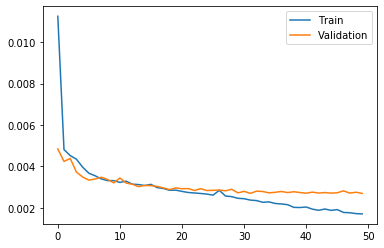

In [0]:
#PRINTS HISTORY OF ERROR THROUGHOUT TRAINING AND VALIDATION
import matplotlib.pyplot as plt
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.show() 

In [0]:
model.load_weights("/content/drive/My Drive/ml project/numpy/weights15001.h5")

In [0]:
from keras.models import load_model
#drive.mount('Nandini')
#model=load_model("Nandini/My Drive/ML/numpy/finalmodel.h5")
model=load_model("/content/drive/My Drive/ml project/numpy/finalmodel.h5")

In [0]:
#TESTING AND SAVING RESULTS
testpath='/content/drive/My Drive/ml project/Test/'
#from google.colab import drive

#testpath='Nandini/My Drive/Test/'
files = os.listdir(testpath)
test=[]
print(files)
for file in files:
    test_img = img_to_array(load_img(testpath+file))
    test_img = resize(test_img, (256,256), anti_aliasing=True)
    test_img*= 1.0/255
    test.append(test_img)

Xtest=[]
Ytest=[]
for test_img in test:
  lab=rgb2lab(test_img)
  l_channel_test = lab[:,:,0]
  ab_channel_test= lab[:,:,1:]/128
  Xtest.append(l_channel_test)
  Ytest.append(ab_channel_test)


Xtest=np.array(Xtest)
Ytest=np.array(Ytest)
Xtest=Xtest.reshape(Xtest.shape+(1,))
print(Xtest.shape)
print("ytest: ",Ytest.shape)

features_test_inception = []
for l in Xtest:
  l= resize(l,(299,299,1))      #because of inception resnet v2
  l=gray2rgb(l)
  l=resize(l,(1,299,299,3))     #sending 1 image to the pretained model
  pred= inception.predict(l)
  pred=pred[0]                  #prediction needs to be reshaped from (1,1000) to 1000
  features_test_inception.append(pred)
features_test_inception=np.array(features_test_inception)
print(features_test_inception.shape)

X_test=[Xtest,features_test_inception]
test_ab = model.predict(X_test)  #model.evaluate()
test_ab = test_ab * 128
print(test_ab.shape)
#test_error = mean((Ytest-test_ab)**2) ##??? need to check if ytest/ab is normalized. loss function is mse.

for i in range(len(test_ab)):
    final_img = np.zeros((256, 256, 3))
    final_img[:,:,0] = Xtest[i][:,:,0]
    final_img[:,:,1:] = test_ab[i]
    imsave('/content/drive/My Drive/ml project/Result/'+str(i)+"finalmse-difflayers.jpg", lab2rgb(final_img))
    #imsave('Nandini/My Drive/Result/'+str(i)+"finalmse-difflayers.jpg", lab2rgb(final_img))